<div style="text-align: center">
    <img src="https://github.com/michal-owsiak/research-on-psychedelic-and-non-psychedelic-mystical-experiences-part-2/raw/main/public/banner.png" width="600" alt="Banner" style="border-radius: 8px">
    <h1><strong>A study of Poles' psychedelic and non-psychedelic mystical experiences in relation to fear of death, emotional empathy, and life satisfaction</strong></h1>
</div>
<div style="text-align: center">
    <h3><strong>Part II: Lingustic analysis</strong></h1>
</div>

# **Imports**

## **Importing libraries**

In [40]:
import pandas as pd
import requests
from wordcloud import STOPWORDS
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt

## **Loading dataset**

In [13]:
dataset_url = "https://github.com/michal-owsiak/research-on-psychedelic-and-non-psychedelic-mystical-experiences-part-2/raw/main/public/dataset.xlsx"
df = pd.read_excel(dataset_url)

# **Data wrangling and cleaning**

## **Joining female and male variables into one dataframe**

In [14]:
columns_to_process = [col[:-2] for col in df.columns if col.endswith("_M")]
combined_columns = {}

for col in columns_to_process:
    male_col = f"{col}_M"
    female_col = f"{col}_F"
    
    if df[male_col].dtype == "float64" and df[female_col].dtype == "float64":
        male_variables = pd.to_numeric(df[male_col], errors="coerce").fillna(0)
        female_variables = pd.to_numeric(df[female_col], errors="coerce").fillna(0)
        
        combined_columns[col] = male_variables + female_variables
        
    elif df[male_col].dtype == "object" and df[female_col].dtype == "object":
        male_variables = df[male_col].fillna("")
        female_variables = df[female_col].fillna("")
        
        combined_columns[col] = male_variables + female_variables

combined_df = pd.DataFrame(combined_columns)

df = pd.concat([df, combined_df], axis=1)

df.drop(columns=[f"{col}_M" for col in columns_to_process] + [f"{col}_F" for col in columns_to_process], inplace=True)

pd.set_option("display.max_columns", None)
df.head()

,start_date,end_date,progress_in_percent,duration_in_seconds,finished,recorded_date,age,sex,survey_version,worldview,education,meditation,compound_never,compound_LSD,compound_psylocybin,compound_ayahuasca,compound_DMT,compound_5MeODMT,compound_mescaline,compound_ibogaine,compound_salvia,compound_other,compound_text,use_amount,microdose,low_dose,average_dose,high_dose,very_high_dose,mystical_experience,context_psychedelic,context_other_psychoactive,context_NDE,context_meditation,context_ritual,context_hypnosis,context_other,context_other_psychoactive_text,context_other_text,trigger_compound,order,intensity,how_long_ago,MEQ30_1,MEQ30_2,MEQ30_3,MEQ30_4,MEQ30_5,MEQ30_6,MEQ30_7,MEQ30_8,MEQ30_9,MEQ30_10,MEQ30_11,MEQ30_12,MEQ30_13,MEQ30_14,MEQ30_15,MEQ30_16,MEQ30_17,MEQ30_18,MEQ30_19,MEQ30_20,MEQ30_21,MEQ30_22,MEQ30_23,MEQ30_24,MEQ30_25,MEQ30_26,MEQ30_27,MEQ30_28,MEQ30_29,MEQ30_30,PES_1,PES_2,PES_3,PES_4,PES_5,PES_6,PES_7,PES_8,PES_9,PES_10,PES_11,SWLS_1,SWLS_2,SWLS_3,SWLS_4,SWLS_5,DAP_R_1,DAP_R_2,DAP_R_3,DAP_R_4,DAP_R_5,DAP_R_6,DAP_R_7,DAP_R_8,influence_empathy,influence_satisfaction,influence_fear,description_text
0,2023-02-17 22:50:49,2023-02-17 23:04:08,100,798,1,2023-02-17 23:04:09,28.0,1.0,1.0,2.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,6.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,,,2.0,0.0,0.0,4.0,6.0,6.0,6.0,6.0,6.0,4.0,5.0,5.0,5.0,6.0,5.0,4.0,6.0,5.0,5.0,5.0,4.0,6.0,5.0,5.0,5.0,6.0,5.0,4.0,4.0,5.0,5.0,5.0,6.0,5.0,4.0,4.0,2.0,5.0,2.0,4.0,3.0,3.0,4.0,4.0,2.0,3.0,4.0,2.0,1.0,3.0,5.0,6.0,7.0,5.0,6.0,7.0,7.0,5.0,2.0,2.0,2.0,
1,2023-02-18 00:24:48,2023-02-18 00:34:16,100,567,1,2023-02-18 00:34:18,30.0,1.0,1.0,4.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,2.0,5.0,3.0,2.0,2.0,3.0,4.0,2.0,1.0,5.0,4.0,4.0,3.0,4.0,3.0,1.0,2.0,3.0,1.0,4.0,4.0,2.0,0.0,0.0,0.0,
2,2023-02-18 12:57:58,2023-02-18 13:13:33,100,934,1,2023-02-18 13:13:33,25.0,2.0,2.0,2.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Haszysz,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Ciastko z haszyszem,,0.0,0.0,0.0,52.0,6.0,4.0,6.0,5.0,6.0,4.0,6.0,4.0,6.0,6.0,6.0,3.0,6.0,5.0,5.0,5.0,3.0,4.0,6.0,4.0,5.0,6.0,1.0,3.0,2.0,5.0,1.0,5.0,6.0,1.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,2.0,2.0,1.0,2.0,1.0,5.0,2.0,2.0,2.0,1.0,3.0,3.0,4.0,
3,2023-02-18 13:14:33,2023-02-18 13:18:33,100,239,1,2023-02-18 13:18:34,22.0,2.0,2.0,4.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,2.0,3.0,2.0,3.0,4.0,3.0,2.0,3.0,4.0,2.0,2.0,3.0,4.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,0.0,0.0,0.0,
4,2023-02-18 13:19:13,2023-02-18 13:26:12,100,419,1,2023-02-18 13:26:13,28.0,2.0,2.0,4.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,2.0,2.0,3.0,3.0,2.0,3.0,4.0,3.0,3.0,4.0,5.0,5.0,6.0,5.0,3.0,2.0,2.0,5.0,2.0,3.0,2.0,2.0,0.0,0.0,0.0,


## **Recoding MEQ30 scorings**

In [15]:
meq30_columns = [col for col in df.columns if col.startswith("MEQ30")]

replacement_mapping = {
    1: 0, 
    2: 1, 
    3: 2, 
    4: 3, 
    5: 4, 
    6: 5
}

df[meq30_columns] = df[meq30_columns].replace(replacement_mapping)

## **Summing the results and checking for complete mystical experiences**

In [16]:
MEQ30_subscales = {
    "Mystical": [4, 5, 6, 9, 14, 15, 16, 18, 20, 21, 23, 24, 25, 26, 28],
    "Positive Mood": [2, 8, 12, 17, 27, 30],
    "Transcendence": [1, 7, 11, 13, 19, 22],
    "Ineffability": [3, 10, 29]
}

for subscale, items in MEQ30_subscales.items():
    df.loc[:, subscale] = df[[f"MEQ30_{item}" for item in items]].sum(axis=1)
    
max_score = {
    "Mystical": len(MEQ30_subscales["Mystical"]) * 5,
    "Positive Mood": len(MEQ30_subscales["Positive Mood"]) * 5,
    "Transcendence": len(MEQ30_subscales["Transcendence"]) * 5,
    "Ineffability": len(MEQ30_subscales["Ineffability"]) * 5
}

df["MEQ_complete"] = (
    (df["Mystical"] / max_score["Mystical"] >= 0.6) &
    (df["Positive Mood"] / max_score["Positive Mood"] >= 0.6) &
    (df["Transcendence"] / max_score["Transcendence"] >= 0.6) &
    (df["Ineffability"] / max_score["Ineffability"] >= 0.6)
).astype(int)

df["MEQ_total_score"] = (
    df["Mystical"] +
    df["Positive Mood"] +
    df["Transcendence"] +
    df["Ineffability"]
)

df.iloc[:10, -6:]

,Mystical,Positive Mood,Transcendence,Ineffability,MEQ_complete,MEQ_total_score
0,60.0,23.0,27.0,15.0,1,125.0
1,0.0,0.0,0.0,0.0,0,0.0
2,50.0,10.0,30.0,15.0,0,105.0
3,0.0,0.0,0.0,0.0,0,0.0
4,0.0,0.0,0.0,0.0,0,0.0
5,15.0,14.0,6.0,3.0,0,38.0
6,62.0,26.0,27.0,13.0,1,128.0
7,0.0,0.0,0.0,0.0,0,0.0
8,0.0,0.0,0.0,0.0,0,0.0
9,0.0,0.0,0.0,0.0,0,0.0


## **Removing incomplete records from the dataset**

In [17]:
incomplete_survey = df[df["finished"] == 0]

df.drop(incomplete_survey.index, inplace=True)
df.reset_index(drop=True, inplace= True)

print(f"We are left with {df.shape[0]} completed surveys.")

We are left with 724 completed surveys.


## **Filtering records that include description of an experience**

In [18]:
df_desc = df[df["description_text"] != ""]
df_desc.reset_index(drop=True, inplace= True)

print(f"Out of these {df.shape[0]} records, {df_desc.shape[0]} participants decided to share a description.")

Out of these 724 records, 338 participants decided to share a description.


# **Translation**

## **Using DeepL REST API**

In [ ]:
def translate(description, target_lang="EN-US", api_key="API_KEY_PLACEHOLDER"):
    url = "https://api.deepl.com/v2/translate"
    params = {
        "auth_key": api_key,
        "text": description,
        "target_lang": target_lang
    }
    response = requests.post(url, data=params)
    result = response.json()
    return result["translations"][0]["text"]

In [ ]:
polish_descriptions = df_desc["description_text"]

english_descriptions = []

for description in polish_descriptions:
    try:
        translated_description = translate(description)
        english_descriptions.append(translated_description)
    except Exception as e:
        print(f"Error translating text: {description}, error: {e}")
        english_descriptions.append(None)

df_translated = df_desc.copy()
df_translated["description_text_EN"] = english_descriptions

In [ ]:
df_translated.to_excel(r"C:\Users\Huawei\Desktop\Data Science\language_analysis\public\dataset_with_english_descriptions.xlsx", index=False)

In [21]:
translated_dataset_url = "https://github.com/michal-owsiak/research-on-psychedelic-and-non-psychedelic-mystical-experiences-part-2/raw/main/public/dataset_with_english_descriptions.xlsx"
df_english = pd.read_excel(translated_dataset_url)

pd.set_option("display.max_colwidth", 1000)
df_english[["description_text", "description_text_EN", "MEQ_total_score", "MEQ_complete"]].head(5)

,description_text,description_text_EN,MEQ_total_score,MEQ_complete
0,"Po ponad 72 godzinach bez snu w trakcie których zażywałem duże ilości mdma, psylocybiny oraz thc - gdy sen w końcu nadszedł, byłem podczas tego praktycznie sto procent świadomy - to ja decydowałem co będzie się działo dalej, podejmując decyzję wynikające z wewnętrznego dialogu. W pewnym momencie poczułem niesamowita błogość i ciepło i zobaczyłem siebie leżącego na łóżku obok mojej partnerki - widziałem siebie, z zaciekawieniem się sobie przyglądałem. To trwało jakieś 5 może 10 minut, podczas których płakałem i cieszyłem się jednocześnie. Zmieniło to moje życie w takim sensie, że zastanawiałem się a co jeśli będąc w takim stanie spotkam kogoś kto też w nim jest? Co się stanie? Czy będziemy mogli się porozumieć?","After more than 72 hours without sleep during which I took large amounts of mdma, psilocybin and thc - when sleep finally came, I was practically one hundred percent conscious during it - I was the one who decided what was going to happen next, making decisions resulting from the internal dialogue. At one point, I felt incredible bliss and warmth and saw myself lying on the bed next to my partner - I could see myself, curiously looking at myself. This went on for about 5 maybe 10 minutes, during which I cried and rejoiced at the same time. It changed my life in the sense that I wondered what if, being in this state, I meet someone who is also in it? What will happen? Will we be able to communicate?",119,1
1,Wyleczyło mnie z dolegliwości które lekarze bezskutecznie leczyli od 15 lat,It cured me of ailments that doctors had been treating for 15 years without success,130,1
2,"Doświadczenie miało miejsce 7 lat temu. Podczas jazdy małym busem bez świateł w środku słuchałam jakiegoś powolnego utworu. Zamknęłam oczy i położyłam głowę na oparciu. Podróż mogła trwać max 20 minut - dla mnie trwała pare godzin. Czułam jakbym ja była w muzyce, nie potrafie tego opisać. Wiedziałam, ze po otwarciu oczu mogłabym wcale już nie być w busie, było błogo, czułam się bezpiecznie, że unoszę się w powietrzu, a nie jestem w swoim ciele, byłam gdzieś daleko. Do teraz nie wiem jak to opisać, ani co to było. To doświadczenie na pewno zostanie ze mną do końca życia jako niesamowite i niewyjaśnione uniesienie.","The experience took place 7 years ago. While driving a small bus with no lights inside, I was listening to some slow song. I closed my eyes and laid my head on the backrest. The trip may have lasted 20 minutes max - for me it lasted a couple of hours. I felt like I was in the music, I can't describe it. I knew that after opening my eyes I might not be in the bus at all anymore, it was blissful, I felt safe, that I was floating in the air, not in my body, I was somewhere far away. To this day I don't know how to describe it or what it was. This experience will definitely stay with me for the rest of my life as an amazing and unexplained rapture.",92,0
3,"Wrazenie podrzymywania mnie jako osoby,które bylo we mnie ale nie ze mnie",Along with holding me up as a person that was in me but not of me,77,0
4,"jak to jest, że coś tak materialnego jak umysł może dać początek czemuś tak niematerialnemu jak doświadczenie?",How is it that something as material as the mind can give rise to something as immaterial as experience?,64,0


# **Data analysis**

## **Word frequency distribution analysis**

In [25]:
concatenated_descriptions = " ".join(df_english["description_text_EN"])

In [34]:
stopwords = set(STOPWORDS)

tokens = word_tokenize(concatenated_descriptions.lower())

filtered_tokens = [
    word for word in tokens if 
    word.isalpha() and word not in stopwords
]

In [47]:
word_frequencies = Counter(filtered_tokens)
top_25_words = word_frequencies.most_common(25)

top_25_words

[('experience', 244),
 ('life', 168),
 ('felt', 135),
 ('time', 117),
 ('body', 80),
 ('everything', 75),
 ('one', 74),
 ('something', 66),
 ('feeling', 64),
 ('experienced', 64),
 ('experiences', 61),
 ('feel', 58),
 ('love', 57),
 ('world', 56),
 ('sense', 53),
 ('know', 50),
 ('state', 48),
 ('death', 48),
 ('saw', 43),
 ('first', 42),
 ('trip', 41),
 ('reality', 41),
 ('people', 40),
 ('able', 38),
 ('many', 38)]

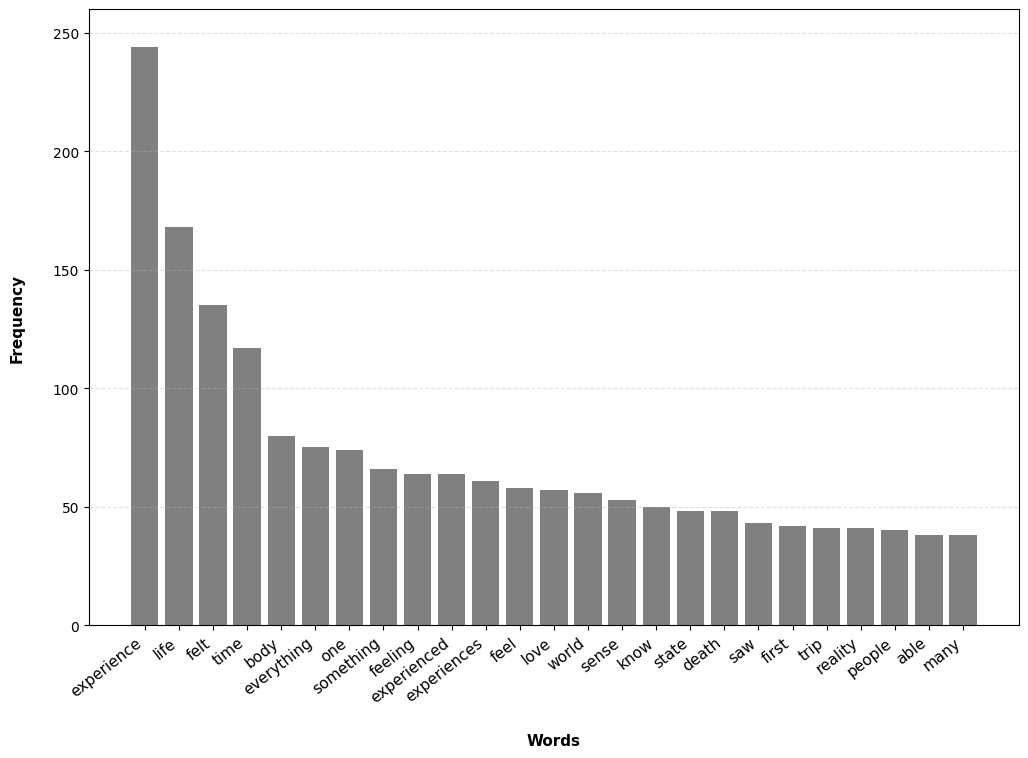

In [67]:
words, frequencies = zip(*top_25_words)

plt.figure(figsize=(12, 8))
plt.bar(words, frequencies, color="grey")
plt.xlabel("Words", fontweight="bold", fontsize="11", labelpad=20)
plt.ylabel("Frequency", fontweight="bold", fontsize="11", labelpad=20)
plt.xticks(rotation=38, ha="right", fontsize="11")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.ylim(0, 260)
plt.show()